**Import the necessary libraries**

Here, Numpy is used to get the homography matrix. OpenCV (cv2) is used to read sample images and select source points, and PIL Image is used to display the raw and projected sample images inside the notebook.

In [1]:
import numpy as np
import cv2
from PIL import Image

**Finding homography matrix**

The function here is used to find the homography matrix that will map image points to the desired destination points.

In [2]:
def find_homography_matrix(src_pts, dst_pts):

    A = np.empty((8,8)) # create an empty matrix A of size 8x8
    b = [] # create an empty list to store the values of destination points

    # next, we need to fill the matrix A with the values from the given points
    for i in range(4):
        x_i = src_pts[i][0] # x_i = x coordinate of ith point in source image
        y_i = src_pts[i][1] # y_i = y coordinate of ith point in source image
        x_i_prime = dst_pts[i][0] # x_i_prime = x coordinate of ith dst point
        y_i_prime = dst_pts[i][1] # y_i_prime = y coordinate of ith dst point
        A[2*i] = [x_i, y_i, 1, 0, 0, 0, -x_i*x_i_prime, -y_i*x_i_prime] # update matrix A
        A[2*i+1] = [0, 0, 0, x_i, y_i, 1, -x_i*y_i_prime, -y_i*y_i_prime] # update matrix A
        b.append(x_i_prime)
        b.append(y_i_prime)

    # using least square estimation, we can find the solution to the matrix Ah = b
    h = np.linalg.lstsq(A, b, rcond=0)[0] # get the least square solution
    h = np.concatenate((h, [1]), axis=0)  # use 1 as the last element of h
    H = h.reshape(3,3) # reshape h into a 3x3 matrix

    return H

**Selecting four (4) source points**

This function lets user to select source points of their choice.

In [3]:
def select_src_pts(img):

    img_copy = img.copy() # copy the image
    
    src_pts = [] # create an empty list to store the points
  
    def mouse_callback(event, x, y, flags, param):
        # store the first 4 points clicked by the user
        if event == cv2.EVENT_LBUTTONDOWN and len(src_pts) < 4:
            src_pts.append([x, y])
            
            cv2.circle(img_copy, (x, y), 5, (0, 255, 0), -1) # draw a circle on the points selected to guide the user

            # connect the points with a line
            if len(src_pts) > 1:
                cv2.line(img_copy, tuple(src_pts[-1]), tuple(src_pts[-2]), (0, 255, 0), 1)
            if len(src_pts) == 4:
                cv2.line(img_copy, tuple(src_pts[-1]), tuple(src_pts[0]), (0, 255, 0), 1)
            
            cv2.imshow('image', img_copy)

    # next, we create a window for user interaction
    cv2.namedWindow('image')
    cv2.setMouseCallback('image', mouse_callback)
    cv2.imshow('image', img_copy)

    # wait for the user to select 4 points
    while len(src_pts) < 4:
        cv2.waitKey(20)
  
    # after selecting 4 poitns, user is given the option to reselect the points,
    # next code gives the instructions to the user        
    cv2.rectangle(img_copy, (0, 0), (275, 65), (255, 255, 255), -1)    
    cv2.putText(img_copy, 'Press r to select again', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
    cv2.putText(img_copy, 'Press any other key to continue', (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)    

    # show the instructions
    cv2.imshow('image', img_copy)

    # if the user wants to reselect, we call the function again. else, we continue
    if cv2.waitKey(0) == ord('r'):
        src_pts = []
        src_pts = select_src_pts(img)
    else:
        cv2.destroyWindow('image')

    # finally, sort src_pts in this order: bottom left, top left, top right, bottom right
    src_pts = sorted(src_pts, key=lambda x: x[0])
    src_pts[0:2] = sorted(src_pts[0:2], key=lambda x: x[1], reverse=True)
    src_pts[2:4] = sorted(src_pts[2:4], key=lambda x: x[1])

    return src_pts


Next, create a function to get the destination points using the selected source points. The side lengths of the object is determined using the selected points. The maximum vertical and horizontal lengths are determined and used as the side lengths of the destination points.

In [4]:
def get_destination_points(src_pts):

    [bottom_left_src, top_left_src, top_right_src, bottom_right_src] = src_pts # read source points

    #get maximum vertical length of the object (i.e., maximum distance between top and bottom points)
    vlen_max = int(max(np.sqrt((bottom_left_src[0] - top_left_src[0])**2 + (bottom_left_src[1] - top_left_src[1])**2),
              np.sqrt((bottom_right_src[0] - top_right_src[0])**2 + (bottom_right_src[1] - top_right_src[1])**2)))

    #get maximum horizontal length of the object (i.e., maximum distance between left and right points)
    hlen_max = int(max(np.sqrt((top_left_src[0] - top_right_src[0])**2 + (top_left_src[1] - top_right_src[1])**2),
                np.sqrt((bottom_left_src[0] - bottom_right_src[0])**2 + (bottom_left_src[1] - bottom_right_src[1])**2)))

    # get the destination points using the maximum vertical and horizontal lengths
    bottom_left_dst = [0,vlen_max-1] # bottom left point of the destination image
    top_left_dst = [0,0] # top left point of the destination image
    top_right_dst = [hlen_max-1,0] # top right point of the destination image
    bottom_right_dst = [hlen_max-1,vlen_max-1] # bottom right point of the destination image

    dst = [bottom_left_dst, top_left_dst, top_right_dst, bottom_right_dst] # collect dst points in a list
    
    return [dst, hlen_max, vlen_max]

**Running the program**

After creating the functions, we can now run the program. First, we need to read the sample images. Then, we need to select the source points. After that, we can get the destination points. Finally, we can get the homography matrix and project the sample image.

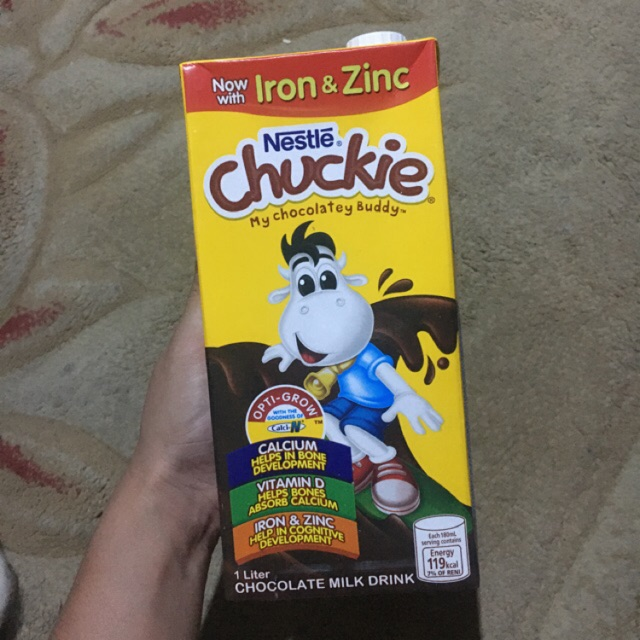

In [5]:
img = cv2.imread('drinkbox.jpg') # read sample image
img_show = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert the cv2 image to RGB format
Image.fromarray(img_show) # show the image

After running the next code below, a window will appear. Choose four points on the image to be used as source points.

In [6]:
src = select_src_pts(img)
[bottom_left_src, top_left_src, top_right_src, bottom_right_src] = src

# print the selected points
print('Bottom left source point: {}'.format(tuple(bottom_left_src)))
print('Top left source point: {}'.format(tuple(top_left_src)))
print('Top right source point: {}'.format(tuple(top_right_src)))
print('Bottom right source point: {}'.format(tuple(bottom_right_src)))

Bottom left source point: (228, 600)
Top left source point: (181, 61)
Top right source point: (436, 37)
Bottom right source point: (479, 578)


Get the destination points using the selected source points.

In [7]:
[dst, hlen_max, vlen_max] = get_destination_points(src)
[bottom_left_dst, top_left_dst, top_right_dst, bottom_right_dst] = dst

# print the destination points
print('Bottom left destination point: {}'.format(tuple(bottom_left_dst)))
print('Top left destination point: {}'.format(tuple(top_left_dst)))
print('Top right destination point: {}'.format(tuple(top_right_dst)))
print('Bottom right destination point: {}'.format(tuple(bottom_right_dst)))

Bottom left destination point: (0, 541)
Top left destination point: (0, 0)
Top right destination point: (255, 0)
Bottom right destination point: (255, 541)


Use the function above to find the homography matrix.

In [8]:
H = find_homography_matrix(src, dst)
H

array([[ 9.94623971e-01, -8.67297341e-02, -1.74736425e+02],
       [ 9.21580840e-02,  9.79179643e-01, -7.64105714e+01],
       [ 9.00647988e-06, -3.08123041e-05,  1.00000000e+00]])

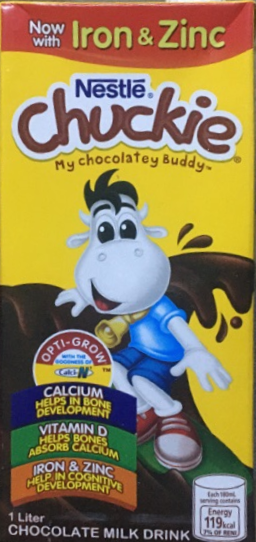

In [9]:
img_mapped = cv2.warpPerspective(img, H, (hlen_max, vlen_max)) # map the image to the destination image using the homography matrix
img_mapped = cv2.cvtColor(img_mapped, cv2.COLOR_BGR2RGB) # convert the cv2 image to RGB format

# finally, show the mapped image
Image.fromarray(img_mapped)